# Complute GQMs to Save

In [35]:
import sys
import os

myhost = os.uname()[1]
print("Running on Computer: [%s]" %myhost)

sys.path.insert(0, '/home/ifernand/Code/') 
dirname = '/home/ifernand/Cloud_SynthData_Proj'

import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from scipy import io as sio
import torch
import time
import h5py

# NDN tools
import NDNT
import NDNT.utils as utils
from NDNT.modules.layers import *
from NDNT.networks import *
import NDNT.NDN as NDN
from NTdatasets.conway.synthcloud_datasets import SimCloudData
from NTdatasets.generic import GenericDataset
from ColorDataUtils.multidata_utils import MultiExperiment
import ColorDataUtils.ConwayUtils as CU
from ColorDataUtils import readout_fit
from ColorDataUtils.simproj_utils import *
from NDNT.utils import fit_lbfgs, fit_lbfgs_batch
from NDNT.utils import imagesc   
from NDNT.utils import ss
from NDNT.utils import subplot_setup

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device0 = torch.device("cpu")
dtype = torch.float32

%load_ext autoreload
%autoreload 2

Running on Computer: [sc]
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [2]:
#out_file = 'data/cloud_data_stim_dim120_robs_sqrad_0.3.hdf5'
start    = time.time()
data     = SimCloudData(cell_type_list=['V1_Exc_L4', 'V1_Inh_L4', 'V1_Exc_L2/3', 'V1_Inh_L2/3'], down_sample=2, num_lags=11)
end      = time.time()
print('CPU Time', end-start, 'sec')

CPU Time 56.66192078590393 sec


In [3]:
# Load baseline LL
GLM_LL = np.load('data/cloud_data_stim_dim_120_sqrad_0.3_GLM_LL.pkl', allow_pickle=True)
GQM_LL = np.load('data/cloud_data_stim_dim_120_sqrad_0.3_GQM_LL.pkl', allow_pickle=True)

In [4]:
cell_idx_dict = data.cell_idx_dict
L4_exc_idx = cell_idx_dict['V1_Exc_L4']
L4_inh_idx = cell_idx_dict['V1_Inh_L4']
L23_exc_idx = cell_idx_dict['V1_Exc_L2/3']
L23_inh_idx = cell_idx_dict['V1_Inh_L2/3']
thetas_dict = data.thetas
V1_thetas = np.concatenate((thetas_dict['V1_Exc_L4'], thetas_dict['V1_Inh_L4'], thetas_dict['V1_Exc_L2/3'], thetas_dict['V1_Inh_L2/3']))
mu0s = data.mu0s

In [5]:
stim_dims = data.stim_dims
num_lags = data.num_lags
L  = stim_dims[1]
NC = data.NC
NT = data.NT
print('stim_dims =', stim_dims)
print('num_lags =', num_lags)
print('L =', L)
print('Number of cells', NC)
print('Number of time points', NT)

stim_dims = [1, 60, 60, 1]
num_lags = 11
L = 60
Number of cells 1491
Number of time points 510000


## GQM and GLM

In [6]:
Treg = 1
L1reg = 1.0
Xreg = 10000.0
GLreg = 10.0

glm_par = Tlayer.layer_dict( 
    input_dims=data.stim_dims, num_filters=1, bias=True, num_lags=data.num_lags, norm_type=0,
    NLtype='softplus', initialize_center=True)
glm_par['reg_vals'] = {'d2x': Xreg, 'd2t': Treg, 'l1': L1reg, 'glocalx': GLreg,'edge_t':10}

In [7]:
Treg = 1
Xreg = 100.0
LOCreg = 10
L1reg = 1.0

# linear layer
glm_layer = Tlayer.layer_dict( 
    input_dims = data.stim_dims, num_filters=1, bias=False, norm_type=0, 
    NLtype='lin', initialize_center=True, num_lags=data.num_lags,
    reg_vals= {'d2x': Xreg, 'd2t': Treg, 'l1': L1reg, 'glocalx': LOCreg,'edge_t':10, 'bcs':{'d2t':1, 'd2x':1}} )

# quadratic layer
gqm_layer = Tlayer.layer_dict( 
    input_dims = data.stim_dims, num_filters=2, bias=False, norm_type=0, 
    NLtype='square', initialize_center=True, num_lags=data.num_lags,
    reg_vals= {'d2x': Xreg, 'd2t': Treg, 'l1': L1reg, 'glocalx': LOCreg,'edge_t':10, 'bcs':{'d2t':1, 'd2x':1}} )

# set up linear and quadratic network
lin_net =  FFnetwork.ffnet_dict( xstim_n='stim', layer_list = [glm_layer] )
quad_net =  FFnetwork.ffnet_dict( xstim_n='stim', layer_list = [gqm_layer] )

# NDN layer that combines quadratic and linear layer
comb_layer = NDNLayer.layer_dict( num_filters=1, NLtype='softplus', bias=True)
comb_layer['weights_initializer'] = 'ones'

# set up combination network
comb_net = FFnetwork.ffnet_dict( xstim_n=None, ffnet_n=[0,1], layer_list=[comb_layer])

## Test

In [8]:
i = 1000
batch_size = 1000
gdata_reg_train = GenericDataset( {'stim': data[data.train_blks[:150]]['stim'],
                               'robs': data[data.train_blks[:150]]['robs'][:,i], 
                               'dfs':data[data.train_blks[:150]]['dfs'][:,i]}, device=device)
gdata_train = GenericDataset( {'stim': data[data.train_blks]['stim'],
                               'robs': data[data.train_blks]['robs'][:,i], 
                               'dfs':data[data.train_blks]['dfs'][:,i]}, device=device)
gdata_val = GenericDataset( {'stim': data[data.val_blks]['stim'], 
                             'robs': data[data.val_blks]['robs'][:,i], 
                             'dfs':data[data.val_blks]['dfs'][:,i]}, device=device)
XregL = None
XregQ = None
GLregL = None
GLregQ = None

In [9]:
rvals = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
rvalsG = [0.1, 1, 10, 100, 1000]

In [10]:
glm_init = NDN( layer_list=[glm_par], loss_type='poisson', seed=100)
glm_init = glm_init.to(device)
fit_lbfgs(glm_init, gdata_reg_train[:], verbose=False)
glm_init = glm_init.to(device0)
LL_rr = glm_init.eval_models(gdata_val[:], device=device, batch_size=batch_size, null_adjusted=True)[0]
print(LL_rr)

0.08695412


In [11]:
gqm_init = NDN( ffnet_list = [lin_net, quad_net, comb_net], loss_type='poisson', seed=100)
gqm_init.set_parameters(val=False,name='weight',ffnet_target=2)
gqm_init = gqm_init.to(device)
fit_lbfgs(gqm_init, gdata_reg_train[:], verbose=False)
gqm_init = gqm_init.to(device0)
LL_rr = gqm_init.eval_models(gdata_val[:], device=device, batch_size=batch_size, null_adjusted=True)[0]
print(LL_rr)

0.038309336


In [14]:
# Linear d2xt reg val
dest_LL = -float('inf')
for rr in range(len(rvals)):
    glm = deepcopy(glm_init)
    glm.networks[0].layers[0].weight.data = glm.networks[0].layers[0].weight.data * 0.9
    glm.networks[0].layers[0].reg.vals['d2xt'] = rvals[rr]
    
    glm = glm.to(device)
    fit_lbfgs(glm, gdata_reg_train[:], verbose=False)
    glm = glm.to(device0)
    LL_rr = glm.eval_models(gdata_val[:], device=device, batch_size=10, null_adjusted=True)[0]

    print(rvals[rr], LL_rr)
    if (rr == 0) or (LL_rr > best_LL):
        best_LL = LL_rr
        XregL = rvals[rr]

0.001 0.08676958
0.01 0.08672643
0.1 0.08677149
1 0.08678293
10 0.08683777
100 0.0877049
1000 0.091991186


In [13]:
# Linear d2xt reg val
dest_LL = -float('inf')
for rr in range(len(rvals)):
    glm = NDN( layer_list=[glm_par], loss_type='poisson')
    glm.networks[0].layers[0].reg.vals['d2xt'] = rvals[rr]
    
    glm = glm.to(device)
    fit_lbfgs(glm, gdata_reg_train[:], verbose=False)
    glm = glm.to(device0)
    LL_rr = glm.eval_models(gdata_val[:], device=device, batch_size=batch_size, null_adjusted=True)[0]

    print(rvals[rr], LL_rr)
    if (rr == 0) or (LL_rr > best_LL):
        best_LL = LL_rr
        XregL = rvals[rr]

0.001 0.08694339
Keyboard interrupt
0.01 -0.8144753
Keyboard interrupt
0.1 -4.0283985
Keyboard interrupt
1 -4.036397
Keyboard interrupt
10 -4.0320225
Keyboard interrupt
100 -4.0694675
Keyboard interrupt
1000 -2.8595889


In [15]:
# Linear G-local reg val
dest_LL = -float('inf')
for rr in range(len(rvalsG)):
    glm = deepcopy(glm_init)
    glm.networks[0].layers[0].weight.data = glm.networks[0].layers[0].weight.data * 0.9
    glm.networks[0].layers[0].reg.vals['d2xt'] = rvals[rr]
    glm.networks[0].layers[0].reg.vals['glocalx'] = rvalsG[rr]
    
    glm = glm.to(device)
    fit_lbfgs(glm, gdata_reg_train[:], verbose=False)
    glm = glm.to(device0)
    LL_rr = glm.eval_models(gdata_val[:], device=device, batch_size=100000, null_adjusted=True)[0]

    print(rvalsG[rr], LL_rr)
    if (rr == 0) or (LL_rr > best_LL):
        best_LL = LL_rr
        GLregL = rvalsG[rr]

0.1 0.0695343
1 0.073632
10 0.08667731
100 0.099169016
1000 0.09798598


In [23]:
# Quad d2xt reg val
dest_LL = -float('inf')
for rr in range(len(rvals)):
    gqm = deepcopy(gqm_init)
    gqm.set_parameters(val=False,name='weight',ffnet_target=2)
    #gqm.networks[0].layers[0].weight.data = gqm.networks[0].layers[0].weight.data * 0.95
    #gqm.networks[1].layers[0].weight.data = gqm.networks[1].layers[0].weight.data * 0.95
    gqm.networks[2].layers[0].bias.data = gqm.networks[2].layers[0].bias.data * 0.99
    gqm.networks[0].layers[0].reg.vals['d2xt'] = XregL
    gqm.networks[0].layers[0].reg.vals['glocalx'] = GLregL
    gqm.networks[1].layers[0].reg.vals['d2xt'] = rvals[rr]
    
    gqm = gqm.to(device)
    fit_lbfgs(gqm, gdata_reg_train[:], verbose=False)
    gqm = gqm.to(device0)
    LL_rr = gqm.eval_models(gdata_val[:], device=device, batch_size=batch_size, null_adjusted=True)[0]
    
    print(rvals[rr], LL_rr)
    if (rr == 0) or (LL_rr > best_LL):
        best_LL = LL_rr
        XregQ = rvals[rr]
        best_gqm = deepcopy(gqm)

0.001 0.04369068
0.01 0.04384184
0.1 0.04422617
1 0.04432392
10 0.044917583
100 0.044089556
1000 0.07748151


In [16]:
# Quad d2xt reg val
dest_LL = -float('inf')
for rr in range(len(rvals)):
    gqm = NDN( ffnet_list = [lin_net, quad_net, comb_net], loss_type='poisson')
    gqm.set_parameters(val=False,name='weight',ffnet_target=2)
    gqm.networks[0].layers[0].reg.vals['d2xt'] = XregL
    gqm.networks[0].layers[0].reg.vals['glocalx'] = GLregL
    gqm.networks[1].layers[0].reg.vals['d2xt'] = rvals[rr]
    
    gqm = gqm.to(device)
    fit_lbfgs(gqm, gdata_reg_train[:], verbose=False)
    gqm = gqm.to(device0)
    LL_rr = gqm.eval_models(gdata_val[:], device=device, batch_size=batch_size, null_adjusted=True)[0]

    print(rvals[rr], LL_rr)
    if (rr == 0) or (LL_rr > best_LL):
        best_LL = LL_rr
        XregQ = rvals[rr]

0.001 0.039460897
0.01 0.039269924
0.1 0.037409782
1 0.03732252
10 0.04306674
100 0.045528412
1000 0.08057332
10000 0.14814067


In [26]:
# Quad G-local reg val
dest_LL = -float('inf')
for rr in range(len(rvalsG)):
    gqm = deepcopy(best_gqm)
    gqm.set_parameters(val=False,name='weight',ffnet_target=2)
    #gqm.networks[0].layers[0].weight.data = gqm.networks[0].layers[0].weight.data * 0.6
    #gqm.networks[1].layers[0].weight.data = gqm.networks[1].layers[0].weight.data * 0.7
    gqm.networks[2].layers[0].bias.data = gqm.networks[2].layers[0].bias.data * 0.99
    gqm.networks[0].layers[0].reg.vals['d2xt'] = XregL
    gqm.networks[0].layers[0].reg.vals['glocalx'] = GLregL
    gqm.networks[1].layers[0].reg.vals['d2xt'] = XregQ
    gqm.networks[1].layers[0].reg.vals['glocalx'] = rvalsG[rr]
        
    gqm = gqm.to(device)
    fit_lbfgs(gqm, gdata_train[:150*data.block_len], verbose=False)
    gqm = gqm.to(device0)
    LL_rr = gqm.eval_models(gdata_val[:], device=device, batch_size=batch_size, null_adjusted=True)[0]

    print(rvalsG[rr], LL_rr)
    if (rr == 0) or (LL_rr > best_LL):
        best_LL = LL_rr
        GLregQ = rvalsG[rr]

0.1 -0.06609392
1 -0.019844532
10 0.07781649
100 0.16217327
1000 0.18893337


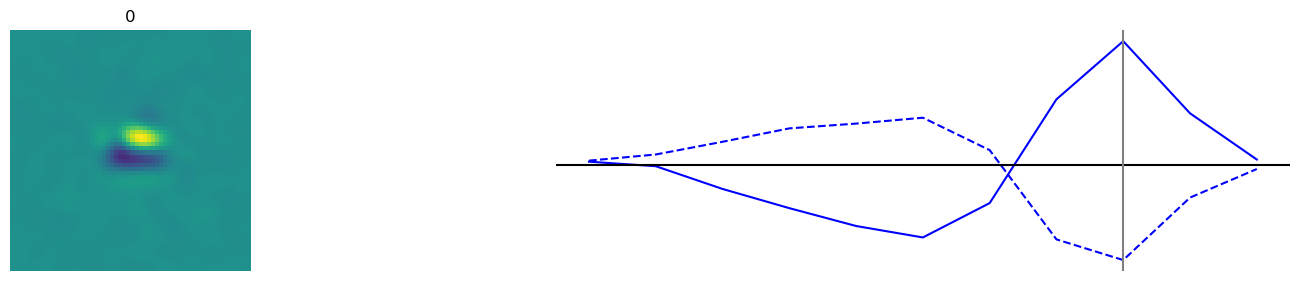

In [63]:
best_model.plot_filters()

In [1]:
# Run init models first

## Big Loop

In [ ]:
batch_size = 100000
gqms = []
glms = []
gqm_LLs = np.zeros(NC)
glm_LLs = np.zeros(NC)

rvals = [0.01, 0.1, 1, 10, 100, 1000]
rvalsG = [0.1, 1, 10, 100, 1000]
for i in range(NC):
    start = time.time()
    XregL = None
    XregQ = None
    GLregL = None
    GLregQ = None
    
    gdata_train = GenericDataset( {'stim': data[data.train_blks]['stim'], 
                        'robs': data[data.train_blks]['robs'][:,i], 
                        'dfs':data[data.train_blks]['dfs'][:,i]}, device=device)
    gdata_val = GenericDataset( {'stim': data[data.val_blks]['stim'], 
                        'robs': data[data.val_blks]['robs'][:,i], 
                        'dfs':data[data.val_blks]['dfs'][:,i]}, device=device)

    # Initial GLM model
    glm_init = NDN( layer_list=[glm_par], loss_type='poisson', seed=100)
    glm_init = glm_init.to(device)
    fit_lbfgs(glm_init, gdata_train[:150*data.block_len], verbose=False)
    glm_init = glm_init.to(device0)

    # Linear d2xt reg val
    dest_LL = -float('inf')
    for rr in range(len(rvals)):
        glm = deepcopy(glm_init)
        glm.networks[0].layers[0].weight.data = glm.networks[0].layers[0].weight.data * 0.9
        glm.networks[0].layers[0].reg.vals['d2xt'] = rvals[rr]
    
        glm = glm.to(device)
        fit_lbfgs(glm, gdata_train[:150*data.block_len], verbose=False)
        glm = glm.to(device0)
        LL_rr = glm.eval_models(gdata_val[:], device=device, batch_size=batch_size, null_adjusted=True)[0]

        if (rr == 0) or (LL_rr > best_LL):
            best_LL = LL_rr
            XregL = rvals[rr]
            best_glm = deepcopy(glm)
    glm_init = best_glm

    # Linear G-local reg val
    dest_LL = -float('inf')
    for rr in range(len(rvalsG)):
        glm = deepcopy(glm_init)
        glm.networks[0].layers[0].weight.data = glm.networks[0].layers[0].weight.data * 0.9
        glm.networks[0].layers[0].reg.vals['d2xt'] = XregL
        glm.networks[0].layers[0].reg.vals['glocalx'] = rvalsG[rr]
    
        glm = glm.to(device)
        fit_lbfgs(glm, gdata_train[:150*data.block_len], verbose=False)
        glm = glm.to(device0)
        LL_rr = glm.eval_models(gdata_val[:], device=device, batch_size=batch_size, null_adjusted=True)[0]

        if (rr == 0) or (LL_rr > best_LL):
            best_LL = LL_rr
            GLregL = rvalsG[rr]
            best_glm = deepcopy(glm)
    glm_init = best_glm

    # Initial GQM model
    gqm_init = NDN( ffnet_list = [lin_net, quad_net, comb_net], loss_type='poisson', seed=100)
    gqm_init.set_parameters(val=False,name='weight',ffnet_target=2)
    gqm_init.networks[0].layers[0].weight.data = glm_init.networks[0].layers[0].weight.data
    gqm_init.networks[0].layers[0].reg.vals['d2xt'] = XregL
    gqm_init.networks[0].layers[0].reg.vals['glocalx'] = GLregL
    gqm_init = gqm_init.to(device)
    fit_lbfgs(gqm_init, gdata_train[:150*data.block_len], verbose=False)
    gqm_init = gqm_init.to(device0)
    
    # Quad d2xt reg val
    dest_LL = -float('inf')
    for rr in range(len(rvals)):
        gqm = deepcopy(gqm_init)
        gqm.set_parameters(val=False,name='weight',ffnet_target=2)
        #gqm.networks[0].layers[0].weight.data = gqm.networks[0].layers[0].weight.data * 0.6
        #gqm.networks[1].layers[0].weight.data = gqm.networks[1].layers[0].weight.data * 0.7
        gqm.networks[2].layers[0].bias.data = gqm.networks[2].layers[0].bias.data * 0.99
        gqm.networks[0].layers[0].reg.vals['d2xt'] = XregL
        gqm.networks[0].layers[0].reg.vals['glocalx'] = GLregL
        gqm.networks[1].layers[0].reg.vals['d2xt'] = rvals[rr]
    
        gqm = gqm.to(device)
        fit_lbfgs(gqm, gdata_train[:150*data.block_len], verbose=False)
        gqm = gqm.to(device0)
        LL_rr = gqm.eval_models(gdata_val[:], device=device, batch_size=batch_size, null_adjusted=True)[0]
    
        if (rr == 0) or (LL_rr > best_LL):
            best_LL = LL_rr
            XregQ = rvals[rr]
            best_gqm = deepcopy(gqm)
    gqm_init = best_gqm

    # Quad G-local reg val
    dest_LL = -float('inf')
    for rr in range(len(rvalsG)):
        gqm = deepcopy(gqm_init)
        gqm.set_parameters(val=False,name='weight',ffnet_target=2)
        #gqm.networks[0].layers[0].weight.data = gqm.networks[0].layers[0].weight.data * 0.6
        #gqm.networks[1].layers[0].weight.data = gqm.networks[1].layers[0].weight.data * 0.7
        gqm.networks[2].layers[0].bias.data = gqm.networks[2].layers[0].bias.data * 0.99
        gqm.networks[0].layers[0].reg.vals['d2xt'] = XregL
        gqm.networks[0].layers[0].reg.vals['glocalx'] = GLregL
        gqm.networks[1].layers[0].reg.vals['d2xt'] = XregQ
        gqm.networks[1].layers[0].reg.vals['glocalx'] = rvalsG[rr]
        
        gqm = gqm.to(device)
        fit_lbfgs(gqm, gdata_train[:150*data.block_len], verbose=False)
        gqm = gqm.to(device0)
        LL_rr = gqm.eval_models(gdata_val[:], device=device, batch_size=batch_size, null_adjusted=True)[0]
    
        if (rr == 0) or (LL_rr > best_LL):
            best_LL = LL_rr
            GLregQ = rvalsG[rr]
            best_gqm = deepcopy(gqm)
    gqm_init = best_gqm

    # run full best GLM
    final_glm = NDN( layer_list=[glm_par], loss_type='poisson')
    final_glm.networks[0].layers[0].weight.data = glm_init.networks[0].layers[0].weight.data
    final_glm.networks[0].layers[0].bias.data = glm_init.networks[0].layers[0].bias.data
    final_glm.networks[0].layers[0].reg.vals['d2xt'] = XregL
    final_glm.networks[0].layers[0].reg.vals['glocalx'] = GLregL
    final_glm = best_glm.to(device)
    fit_lbfgs(final_glm, gdata_train[:], verbose=False)
    final_glm = final_glm.to(device0)
    best_glm_LL = final_glm.eval_models(gdata_val[:], device=device, batch_size=batch_size, null_adjusted=True)[0]

    # run full best GQM
    final_gqm = NDN( ffnet_list = [lin_net, quad_net, comb_net], loss_type='poisson')
    final_gqm.set_parameters(val=False,name='weight',ffnet_target=2)
    final_gqm.networks[0].layers[0].weight.data = gqm_init.networks[0].layers[0].weight.data
    final_gqm.networks[1].layers[0].weight.data = gqm_init.networks[1].layers[0].weight.data
    final_gqm.networks[2].layers[0].bias.data = gqm_init.networks[2].layers[0].bias.data
    final_gqm.networks[0].layers[0].reg.vals['d2xt'] = XregL
    final_gqm.networks[0].layers[0].reg.vals['glocalx'] = GLregL
    final_gqm.networks[1].layers[0].reg.vals['d2xt'] = XregQ
    final_gqm.networks[1].layers[0].reg.vals['glocalx'] = GLregQ
    final_gqm = final_gqm.to(device)
    fit_lbfgs(final_gqm, gdata_train[:], verbose=False)
    final_gqm = final_gqm.to(device0)
    best_gqm_LL = final_gqm.eval_models(gdata_val[:], device=device, batch_size=batch_size, null_adjusted=True)[0]
    
    gqms.append(final_gqm)
    glms.append(final_glm)
    gqm_LLs[i] = best_gqm_LL
    glm_LLs[i] = best_glm_LL
    end = time.time()
    print('Cell', i, 'complete', end-start, 'sec')

    gdata_train = None
    gdata_val = None

Cell 0 complete 427.8607828617096 sec
Cell 1 complete 459.8611259460449 sec
Cell 2 complete 387.4780125617981 sec
Cell 3 complete 483.0410430431366 sec
Cell 4 complete 426.5385866165161 sec
Cell 5 complete 449.78764939308167 sec
Cell 6 complete 379.32380414009094 sec
Cell 7 complete 465.6131205558777 sec
Cell 8 complete 485.4647979736328 sec
Cell 9 complete 455.85818338394165 sec
Cell 10 complete 418.8387668132782 sec
Cell 11 complete 477.09847116470337 sec
Cell 12 complete 404.42548084259033 sec
Cell 13 complete 399.50138235092163 sec
Cell 14 complete 474.34901666641235 sec
Cell 15 complete 416.0291392803192 sec
Cell 16 complete 461.9897975921631 sec
Cell 17 complete 422.42485904693604 sec
Cell 18 complete 470.2955071926117 sec
Cell 19 complete 410.9702994823456 sec
Cell 20 complete 431.14353227615356 sec
Cell 21 complete 430.16494822502136 sec
Cell 22 complete 419.49125504493713 sec
Cell 23 complete 461.81332182884216 sec
Cell 24 complete 517.8998000621796 sec
Cell 25 complete 389.94

In [12]:
len(glms)

1491

In [9]:
print('Done')

Done


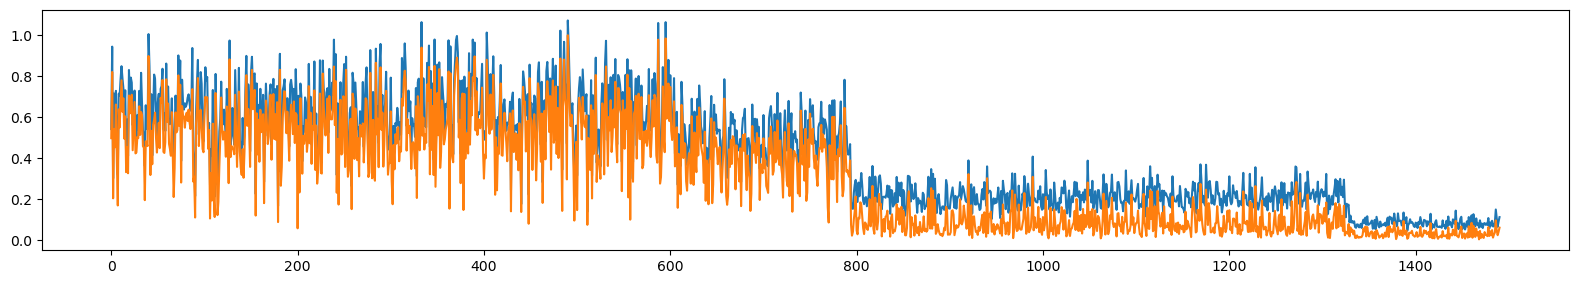

In [13]:
ss()
plt.plot(gqm_LLs)
plt.plot(glm_LLs)

In [14]:
all_gqm_weights = np.zeros((NC,L,L,num_lags,3))
for i in range(NC):
    all_gqm_weights[i,:,:,:,0] = gqms[i].get_weights(ffnet_target=0)[:,:,:,0] # lin weights
    all_gqm_weights[i,:,:,:,1] = gqms[i].get_weights(ffnet_target=1)[:,:,:,0] # quad 1 weights
    all_gqm_weights[i,:,:,:,2] = gqms[i].get_weights(ffnet_target=1)[:,:,:,1] # quad 2 weights
print(all_gqm_weights.shape)

(1491, 60, 60, 11, 3)


In [15]:
import pickle
with open('data/2-28_update_all_neuron_GQM_weights_sqrad_0.3_.pkl', 'wb') as f:
    pickle.dump(all_gqm_weights, f)

In [31]:
all_glm_weights = np.zeros((NC,L,L,num_lags))
for i in range(NC):
    all_glm_weights[i,:,:,:] = gqms[i].get_weights(ffnet_target=0)[:,:,:,0] # lin weights
print(all_glm_weights.shape)

(1491, 60, 60, 11)


In [32]:
import pickle
with open('data/2-28_update_all_neuron_GLM_weights_sqrad_0.3_.pkl', 'wb') as f:
    pickle.dump(all_glm_weights, f)

## Weights

In [26]:
cell = 1400
lin = gqms[cell].get_weights(ffnet_target=0)[:,:,:,0] # lin weights
quad1 = gqms[cell].get_weights(ffnet_target=1)[:,:,:,0] # quad 1 weights
quad2 = gqms[cell].get_weights(ffnet_target=1)[:,:,:,1] # quad 2 weights

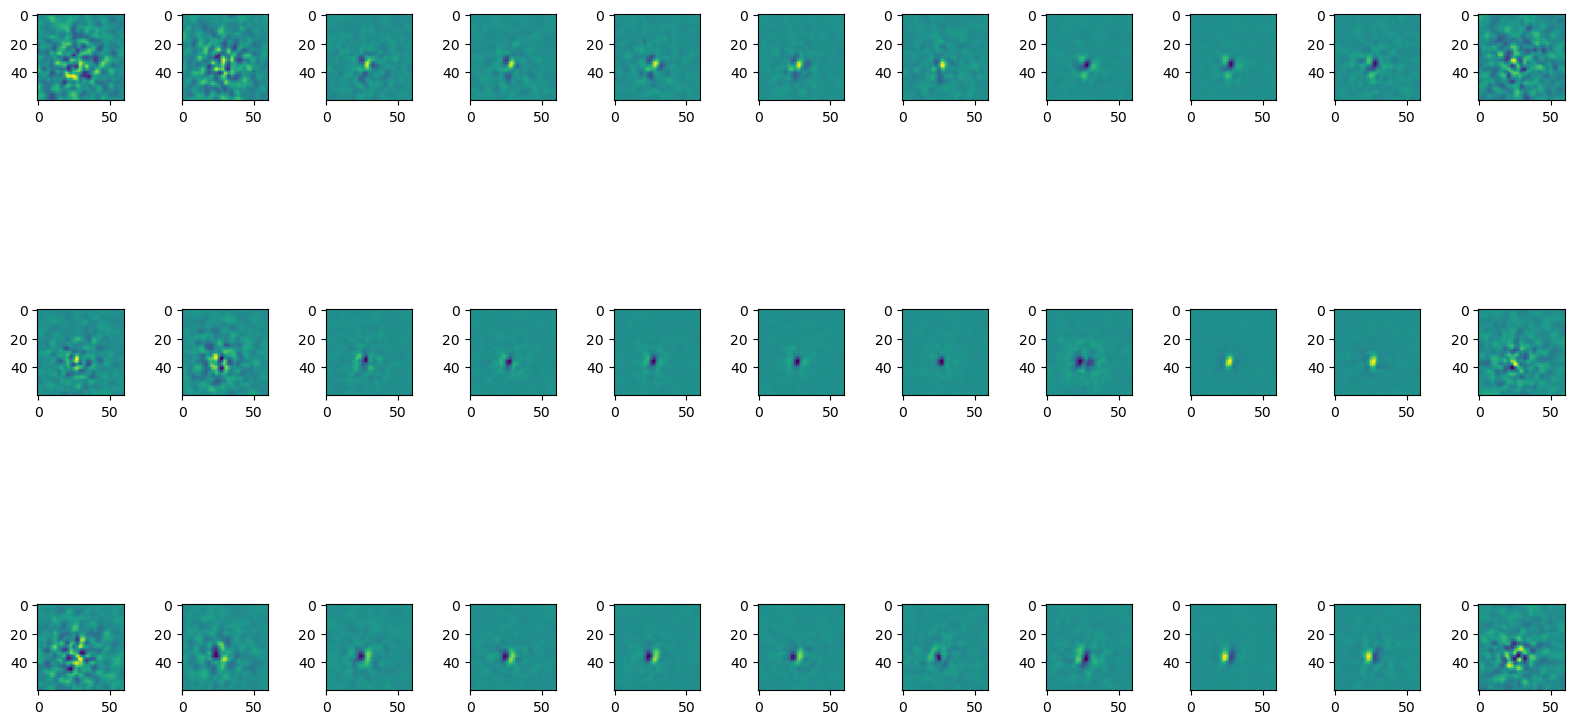

In [27]:
ss(3,11)
k = 1
for i in range(11):
    plt.subplot(3,11,k)
    imagesc(lin[:,:,i], balanced=True)
    k += 1
for i in range(11):
    plt.subplot(3,11,k)
    imagesc(quad1[:,:,i], balanced=True)
    k += 1
for i in range(11):
    plt.subplot(3,11,k)
    imagesc(quad2[:,:,i], balanced=True)
    k += 1
plt.show()

## Complexity

In [28]:
complexity = np.zeros(NC)
for i in range(NC):
    gdata = GenericDataset( {'stim': data[data.val_blks]['stim'], 
                         'robs': data[data.val_blks]['robs'][:,i], 
                         'dfs':data[data.val_blks]['dfs'][:,i]}, device=device)

    gqm = gqms[i].to(device)
    lin_pred = gqm.networks[0](gdata[:]['stim']).detach().cpu().numpy()[:,0]
    quad_pred = np.sum(gqm.networks[1](gdata[:]['stim']).detach().cpu().numpy(),axis=1) # + gqm[i].networks[2](gdata[:]['stim']).detach().cpu().numpy()
    gqm = gqm.to(device0)

    lin_var = np.var(lin_pred)
    quad_var = np.var(quad_pred)
    complexity[i] = lin_var/(lin_var+quad_var)

    print('Cell', i, 'complexity computed')
    gdata = None

Cell 0 complexity computed
Cell 1 complexity computed
Cell 2 complexity computed
Cell 3 complexity computed
Cell 4 complexity computed
Cell 5 complexity computed
Cell 6 complexity computed
Cell 7 complexity computed
Cell 8 complexity computed
Cell 9 complexity computed
Cell 10 complexity computed
Cell 11 complexity computed
Cell 12 complexity computed
Cell 13 complexity computed
Cell 14 complexity computed
Cell 15 complexity computed
Cell 16 complexity computed
Cell 17 complexity computed
Cell 18 complexity computed
Cell 19 complexity computed
Cell 20 complexity computed
Cell 21 complexity computed
Cell 22 complexity computed
Cell 23 complexity computed
Cell 24 complexity computed
Cell 25 complexity computed
Cell 26 complexity computed
Cell 27 complexity computed
Cell 28 complexity computed
Cell 29 complexity computed
Cell 30 complexity computed
Cell 31 complexity computed
Cell 32 complexity computed
Cell 33 complexity computed
Cell 34 complexity computed
Cell 35 complexity computed
Ce

In [29]:
np.save('data/2-28_update_all_neuron_complexity_sqrad_0.3.npy', complexity)

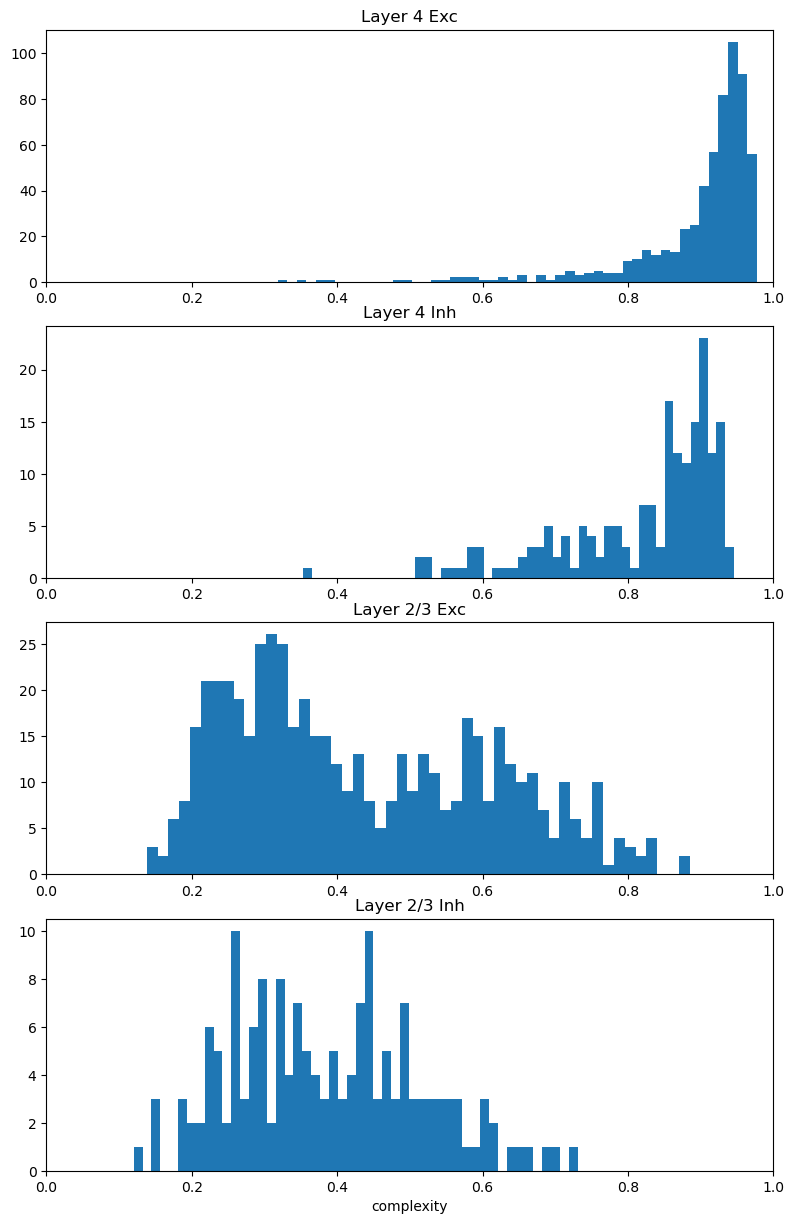

In [39]:
subplot_setup(4, 1, row_height=3, fig_width=8)
plt.subplot(4,1,1)
plt.hist(complexity[L4_exc_idx],50)
plt.title('Layer 4 Exc')
plt.xlim([0,1])

plt.subplot(4,1,2)
plt.hist(complexity[L4_inh_idx],50)
plt.title('Layer 4 Inh')
plt.xlim([0,1])

plt.subplot(4,1,3)
plt.hist(complexity[L23_exc_idx],50)
plt.title('Layer 2/3 Exc')
plt.xlim([0,1])

plt.subplot(4,1,4)
plt.hist(complexity[L23_inh_idx],50)
plt.title('Layer 2/3 Inh')
plt.xlim([0,1])
plt.xlabel('complexity')

plt.show()

## Baseline Log-Likelyhood

In [30]:
np.save('data/2-28_update_cloud_data_stim_dim_120_sqrad_0.3_GQM_LL.npy',gqm_LLs)
np.save('data/2-28_update_cloud_data_stim_dim_120_sqrad_0.3_GLM_LL.npy',glm_LLs)